In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import exploring_script as es
import importlib
importlib.reload(es)
import pandas as pd
import swifter
import numpy as np
from fink_utils.photometry.vect_conversion import vect_dc_mag

In [4]:
from swifter import set_defaults
set_defaults(
    npartitions=None,
    dask_threshold=1,
    scheduler="processes",
    progress_bar=True,
    progress_bar_desc=None,
    allow_dask_on_strings=False,
    force_parallel=True,
)

In [5]:
confirmed_sso = es.load_data(columns=["ssnamenr", "fid", 'magpsf', 'sigmapsf', 'magnr', 'sigmagnr', 'magzpsci', 'isdiffpos', "jd", "nid"])

In [6]:
confirmed_sso["dcmag"], confirmed_sso["sigdcmag"] = vect_dc_mag(
    confirmed_sso["fid"],
    confirmed_sso["magpsf"],
    confirmed_sso["sigmapsf"],
    confirmed_sso["magnr"],
    confirmed_sso["sigmagnr"],
    confirmed_sso["magzpsci"],
    confirmed_sso["isdiffpos"]
)

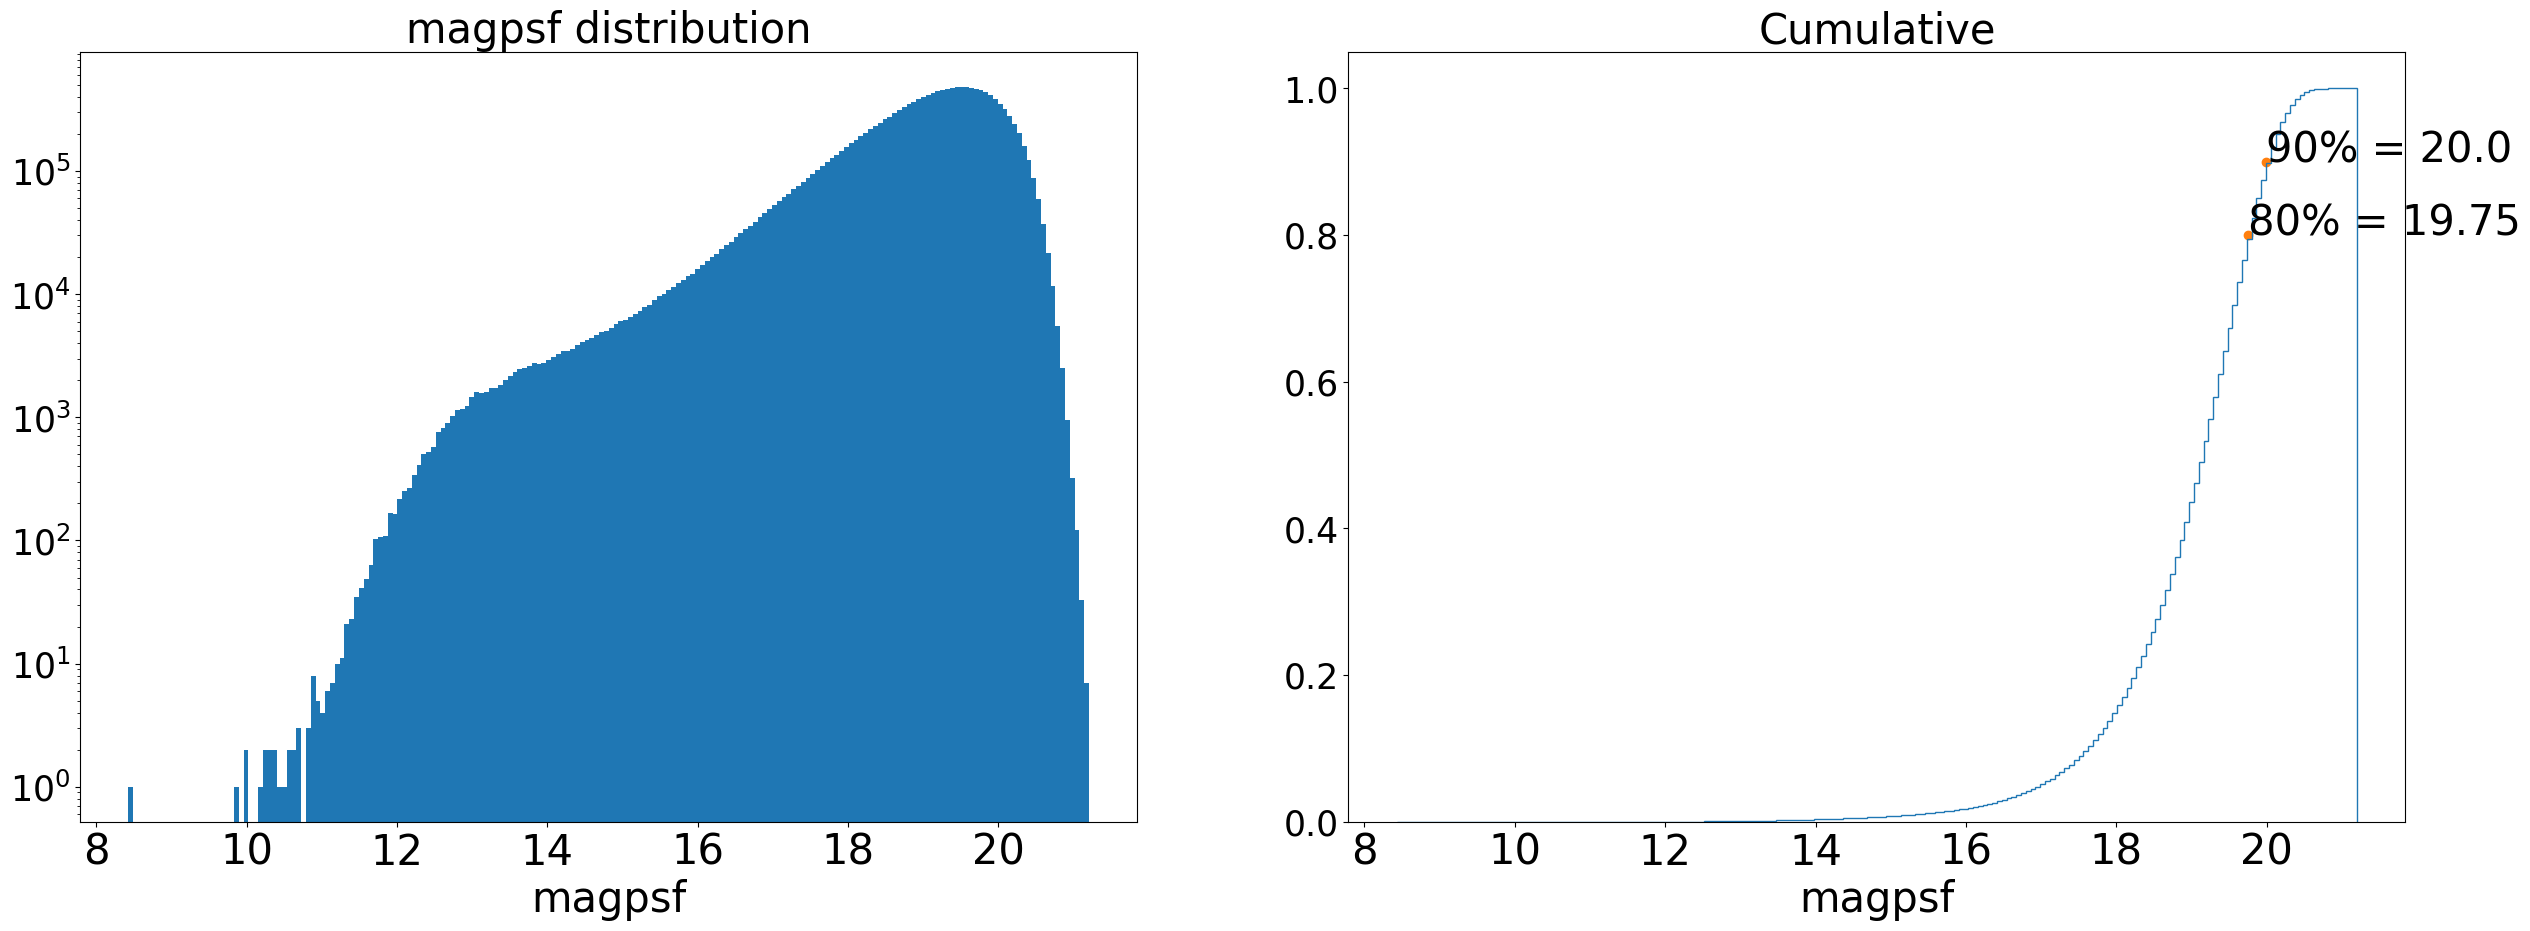

In [6]:
es.plot_hist_and_cdf(confirmed_sso["magpsf"], None, "magpsf distribution", "magpsf", "", None, "Cumulative", "magpsf", "")

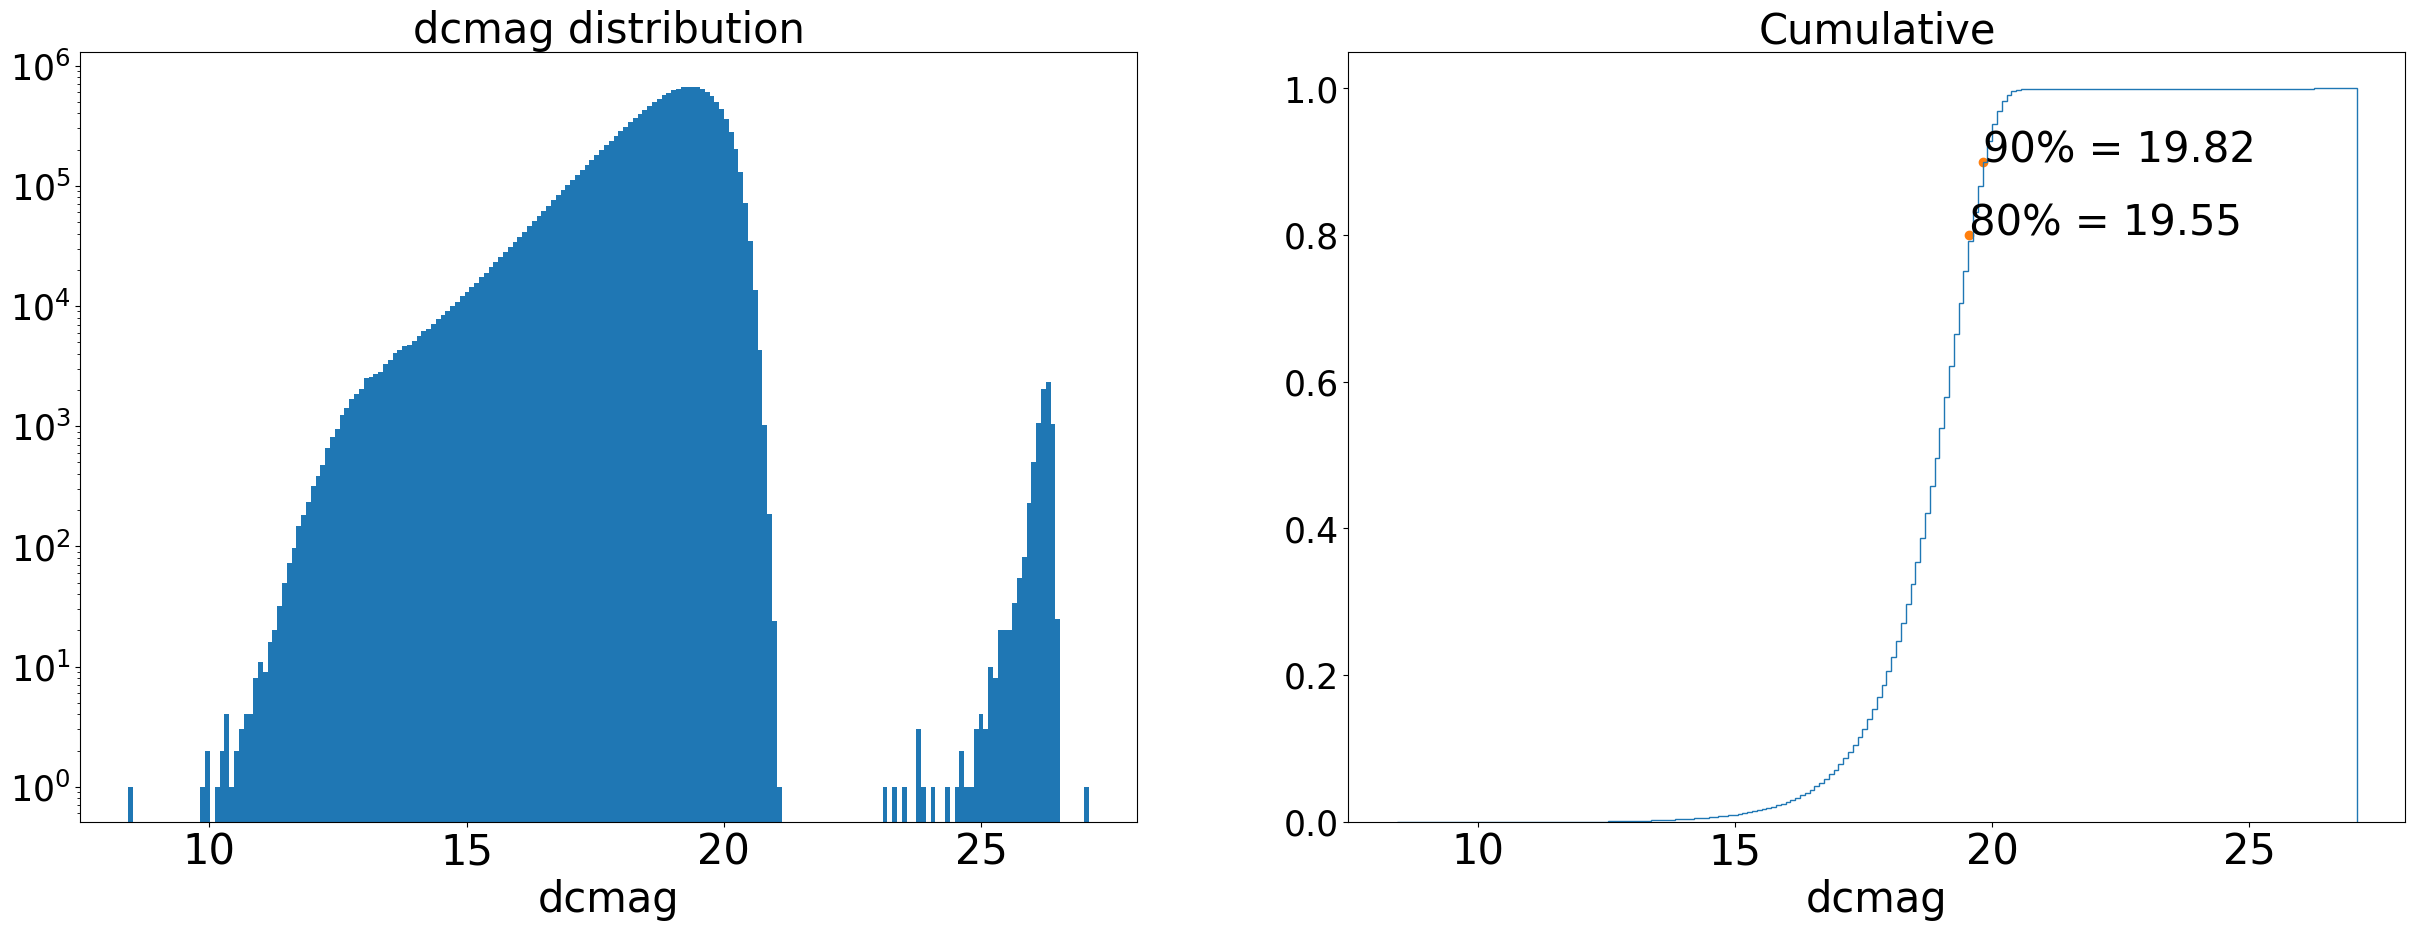

In [7]:
es.plot_hist_and_cdf(confirmed_sso["dcmag"], None, "dcmag distribution", "dcmag", "", None, "Cumulative", "dcmag", "")

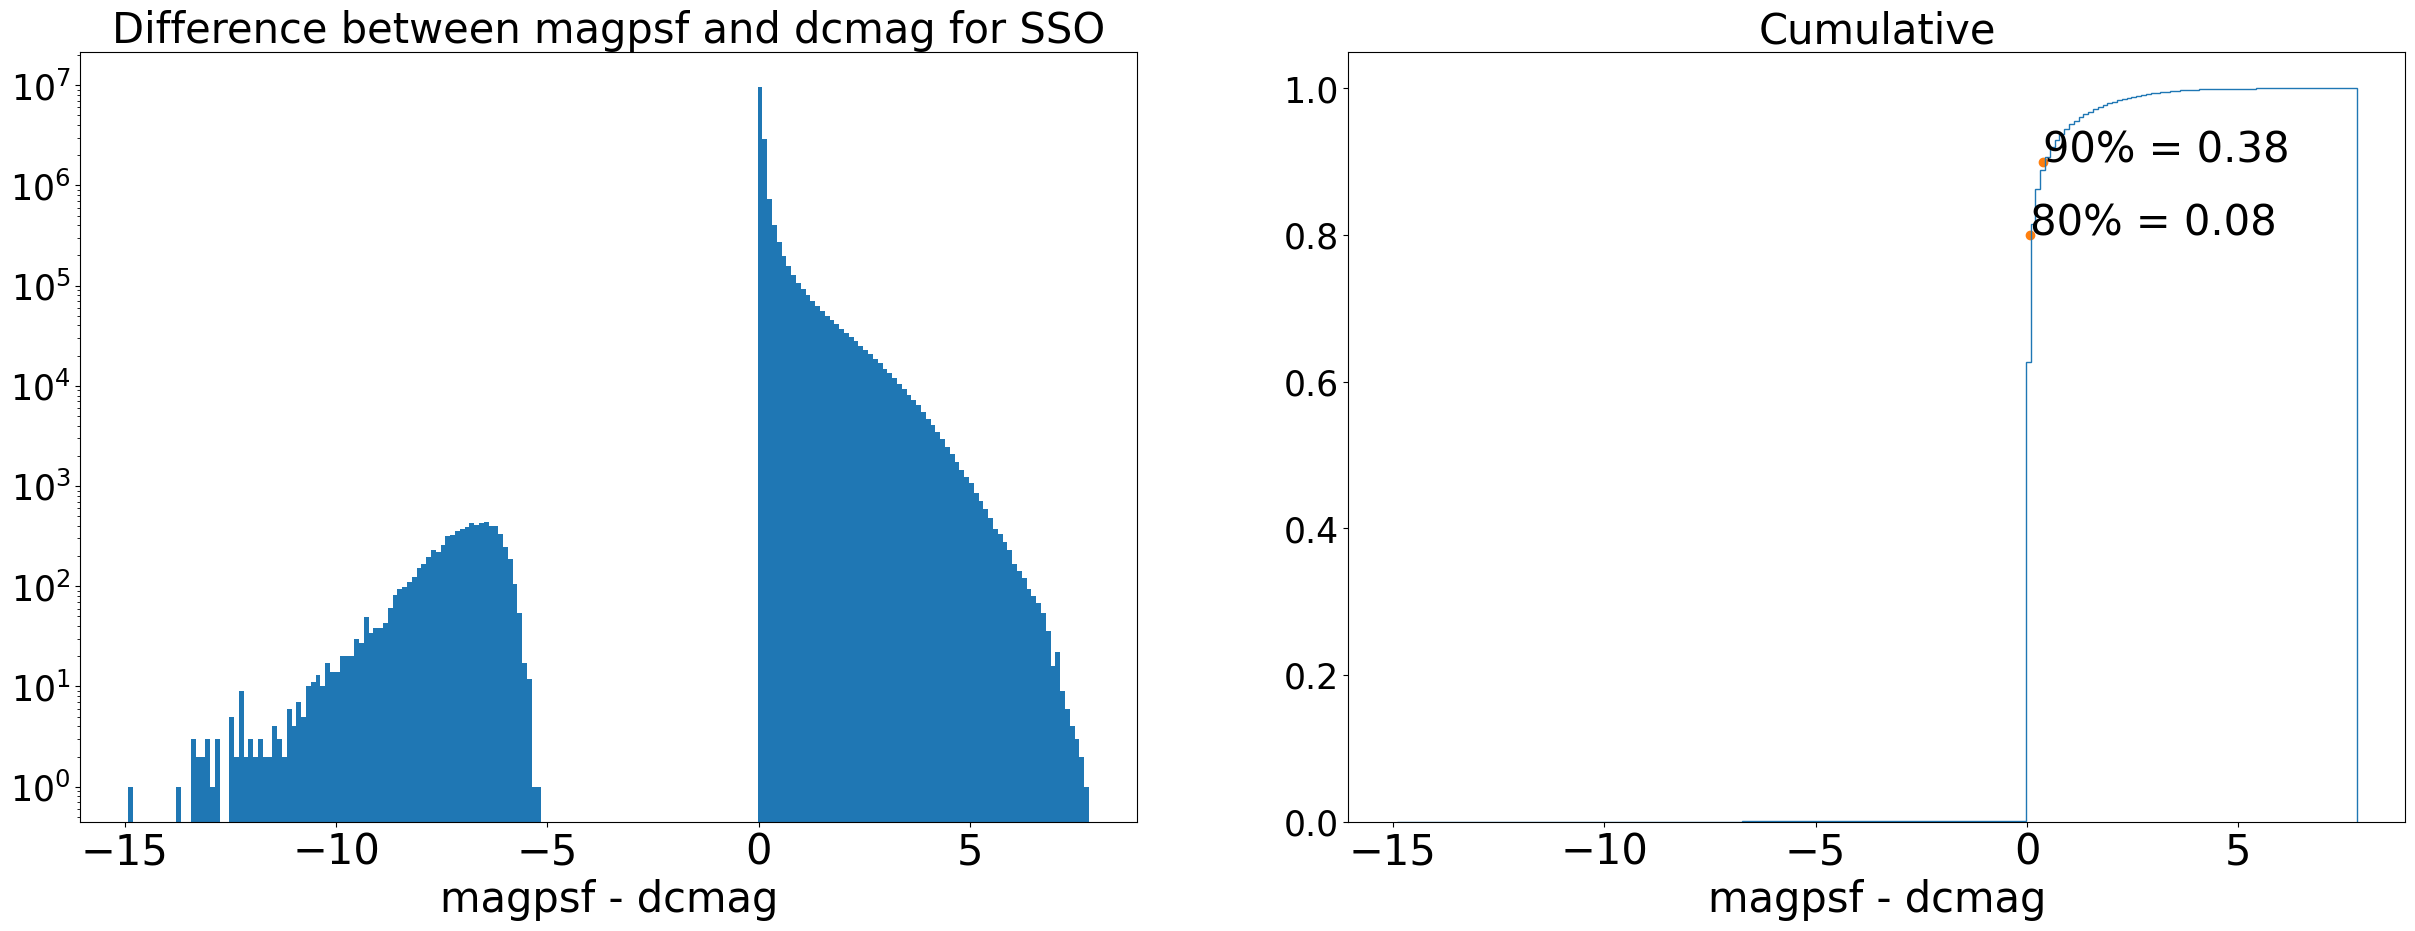

In [8]:
es.plot_hist_and_cdf((confirmed_sso["magpsf"] - confirmed_sso["dcmag"]), None, "Difference between magpsf and dcmag for SSO", "magpsf - dcmag", "", None, "Cumulative", "magpsf - dcmag", "")

In [9]:
prep_rate_gb = confirmed_sso.sort_values("jd").groupby("ssnamenr").agg(list)

In [10]:
rate_and_color = prep_rate_gb.swifter.apply(es.mag_df, axis=1)

/home/roman/Documents/Doctorat/Asteroids/fink-fat/notebook/parameters_selection/exploring_script.py:165: RuntimeWarning: invalid value encountered in true_divide
  dmag_fid1 = np.divide(diff_mag1, diff_jd1)


Pandas Apply:   0%|          | 0/517611 [00:00<?, ?it/s]

/home/roman/Documents/Doctorat/Asteroids/fink-fat/notebook/parameters_selection/exploring_script.py:166: RuntimeWarning: divide by zero encountered in true_divide
  dmag_fid2 = np.divide(diff_mag2, diff_jd2)
/home/roman/Documents/Doctorat/Asteroids/fink-fat/notebook/parameters_selection/exploring_script.py:165: RuntimeWarning: invalid value encountered in true_divide
  dmag_fid1 = np.divide(diff_mag1, diff_jd1)
/home/roman/Documents/Doctorat/Asteroids/fink-fat/notebook/parameters_selection/exploring_script.py:165: RuntimeWarning: divide by zero encountered in true_divide
  dmag_fid1 = np.divide(diff_mag1, diff_jd1)


In [11]:
rate_g = rate_and_color.explode().reset_index(drop=True)[::3].explode().reset_index(drop=True).replace([np.inf], np.nan).dropna()
rate_r = rate_and_color.explode().reset_index(drop=True)[1::3].explode().reset_index(drop=True).replace([np.inf], np.nan).dropna()
color = rate_and_color.explode().reset_index(drop=True)[2::3].explode().reset_index(drop=True)
color = color[color != 0]

/home/roman/anaconda3/envs/fink_fat_env/lib/python3.7/site-packages/swifter/swifter.py:88: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  "This pandas object has duplicate indices, "


### Magnitude study (all alerts)

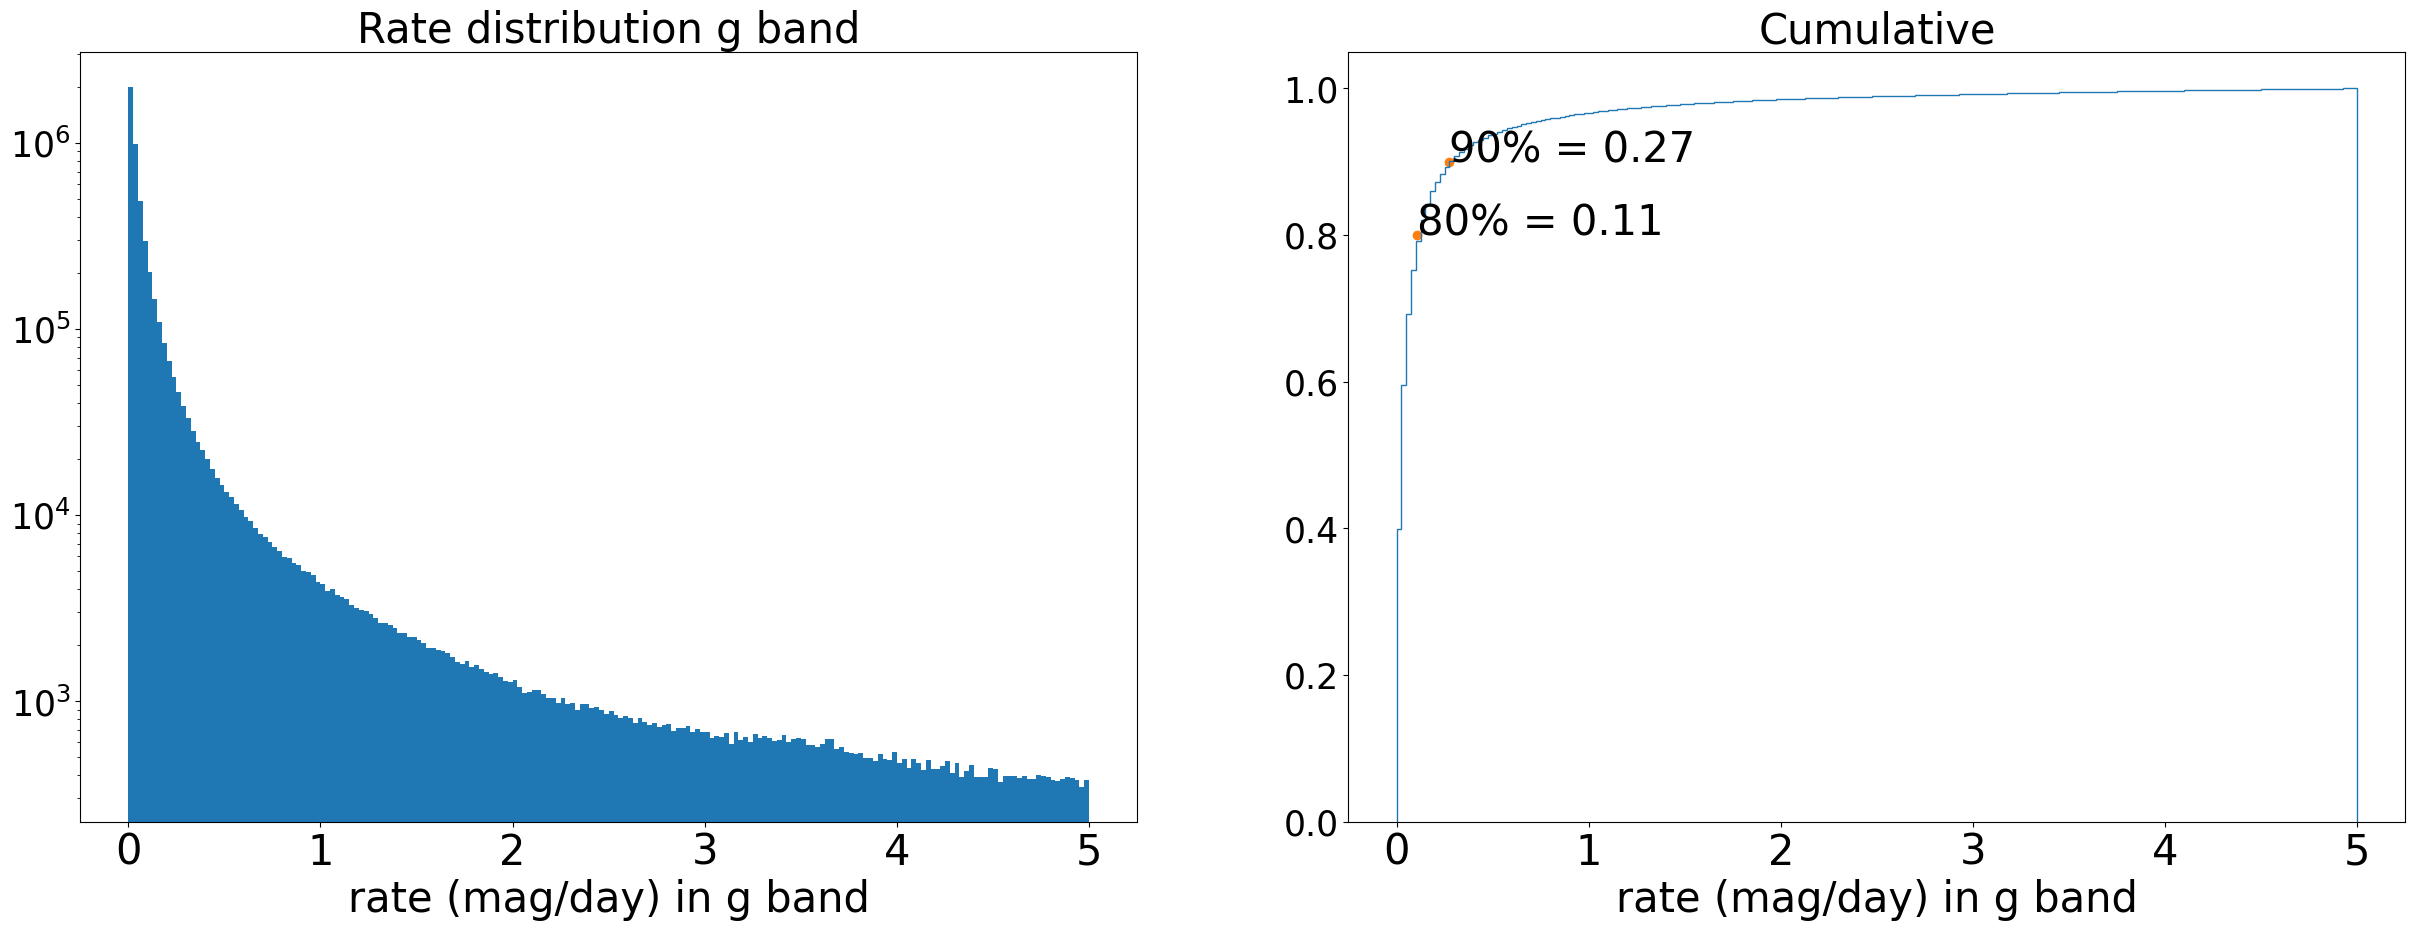

In [12]:
es.plot_hist_and_cdf(rate_g, [0, 5], "Rate distribution g band", "rate (mag/day) in g band", "", [0, 5], "Cumulative", "rate (mag/day) in g band", "")

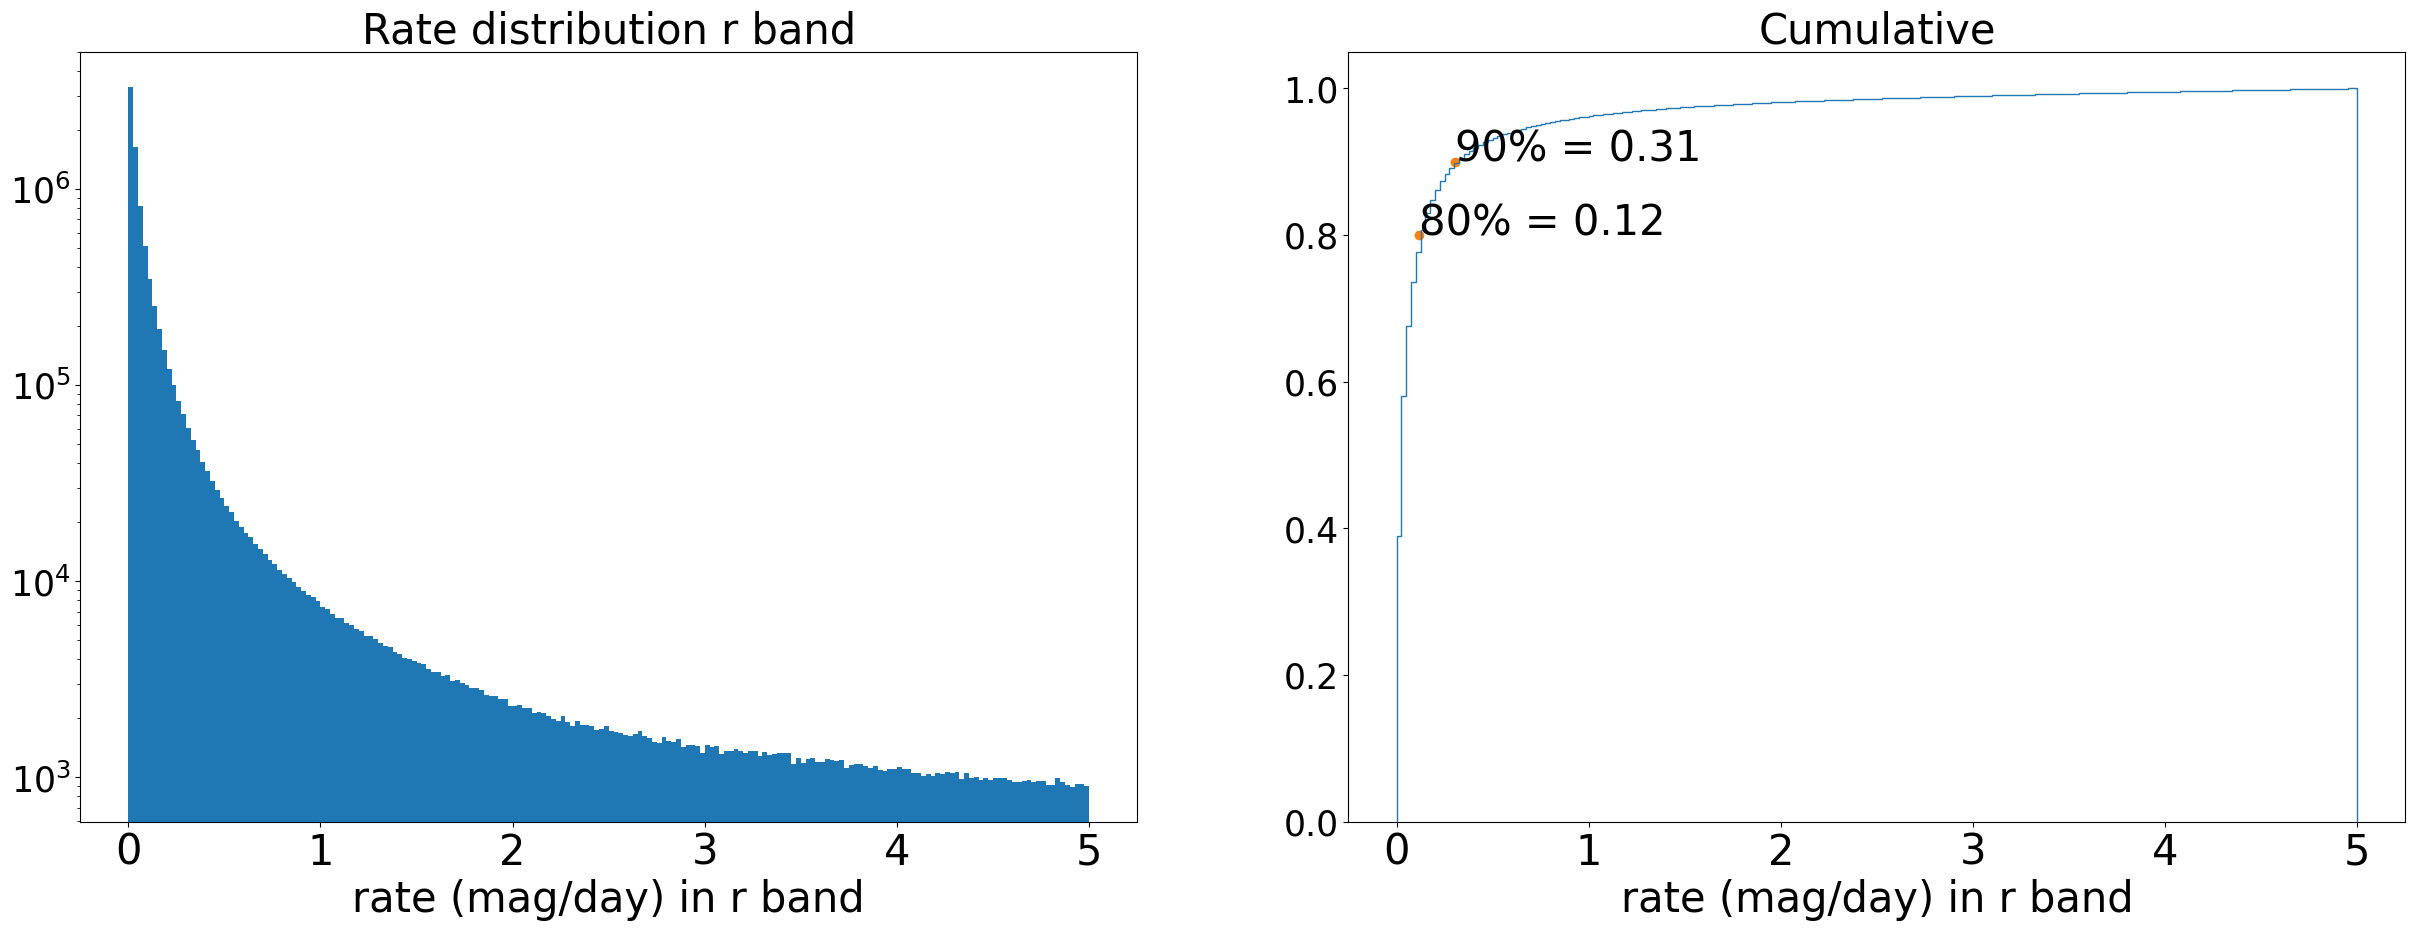

In [13]:
es.plot_hist_and_cdf(rate_r, [0, 5], "Rate distribution r band", "rate (mag/day) in r band", "", [0, 5], "Cumulative", "rate (mag/day) in r band", "")

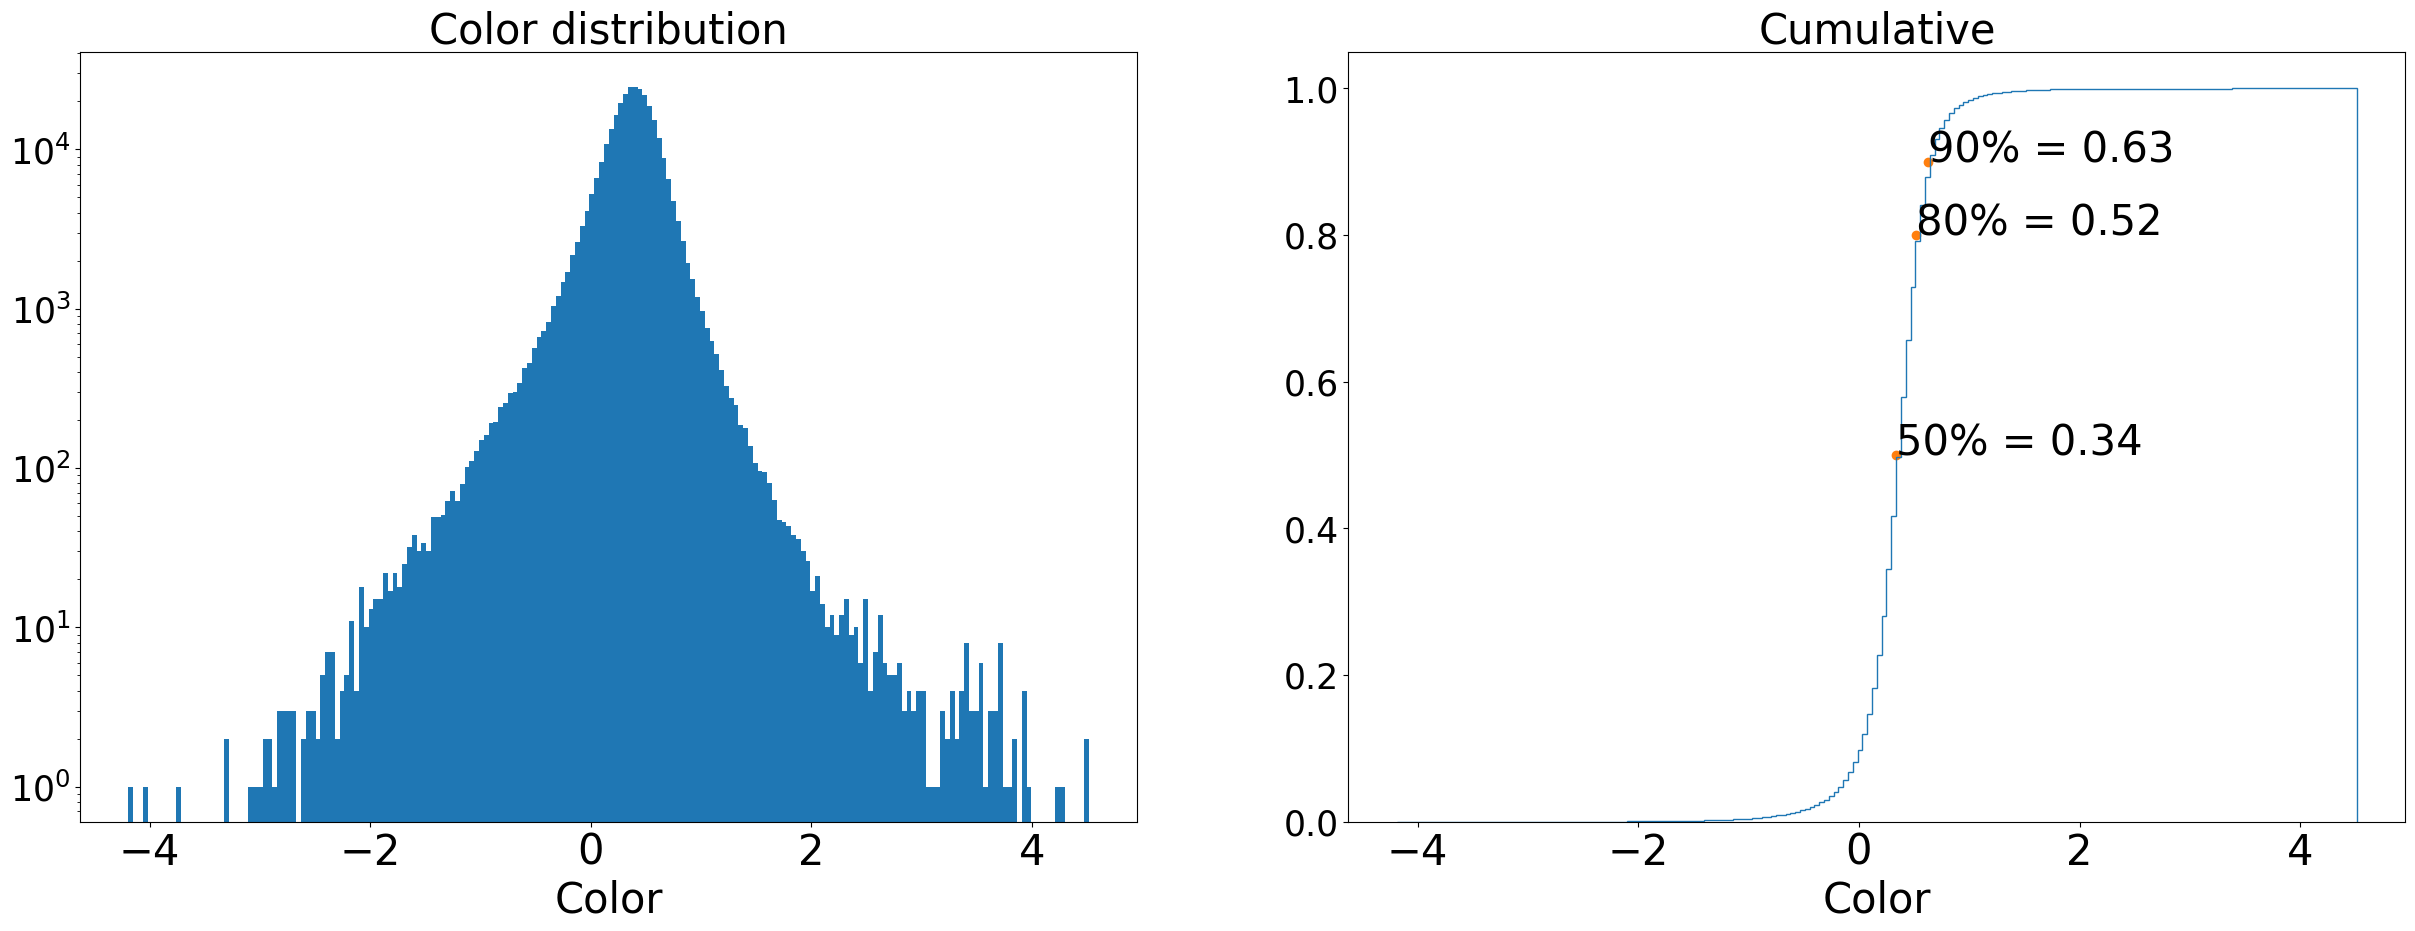

In [14]:
es.plot_hist_and_cdf(color, None, "Color distribution", "Color", "", None, "Cumulative", "Color", "", percent_cdf=[0.5, 0.8, 0.9])

### Magnitude study (intra night alerts)

In [7]:
prep_intra_rate_gb = confirmed_sso[["ssnamenr", "nid", "jd", "dcmag", "fid"]].sort_values("jd").groupby(["nid", "ssnamenr"]).agg(
    jd=("jd", list),
    dcmag=("dcmag", list),
    fid=("fid", list),
    nb_obs=("dcmag", len)
)

In [8]:
prep_intra_rate = prep_intra_rate_gb[prep_intra_rate_gb["nb_obs"] > 1]

In [9]:
intra_rate_and_color = prep_intra_rate.reset_index(drop=True).swifter.apply(es.mag_df, axis=1)

Pandas Apply:   0%|          | 0/4136628 [00:00<?, ?it/s]

/home/roman/Documents/Doctorat/Asteroids/fink-fat/notebook/parameters_selection/exploring_script.py:166: RuntimeWarning: divide by zero encountered in true_divide
  dmag_fid2 = np.divide(diff_mag2, diff_jd2)
/home/roman/Documents/Doctorat/Asteroids/fink-fat/notebook/parameters_selection/exploring_script.py:165: RuntimeWarning: divide by zero encountered in true_divide
  dmag_fid1 = np.divide(diff_mag1, diff_jd1)
/home/roman/Documents/Doctorat/Asteroids/fink-fat/notebook/parameters_selection/exploring_script.py:165: RuntimeWarning: invalid value encountered in true_divide
  dmag_fid1 = np.divide(diff_mag1, diff_jd1)


In [10]:
intra_rate_g = intra_rate_and_color.explode().reset_index(drop=True)[::3].explode().reset_index(drop=True).replace([np.inf], np.nan).dropna()
intra_rate_r = intra_rate_and_color.explode().reset_index(drop=True)[1::3].explode().reset_index(drop=True).replace([np.inf], np.nan).dropna()
intra_color = intra_rate_and_color.explode().reset_index(drop=True)[2::3].explode().reset_index(drop=True)
intra_color = intra_color[intra_color != 0]

/home/roman/anaconda3/envs/fink_fat_env/lib/python3.7/site-packages/swifter/swifter.py:88: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  "This pandas object has duplicate indices, "


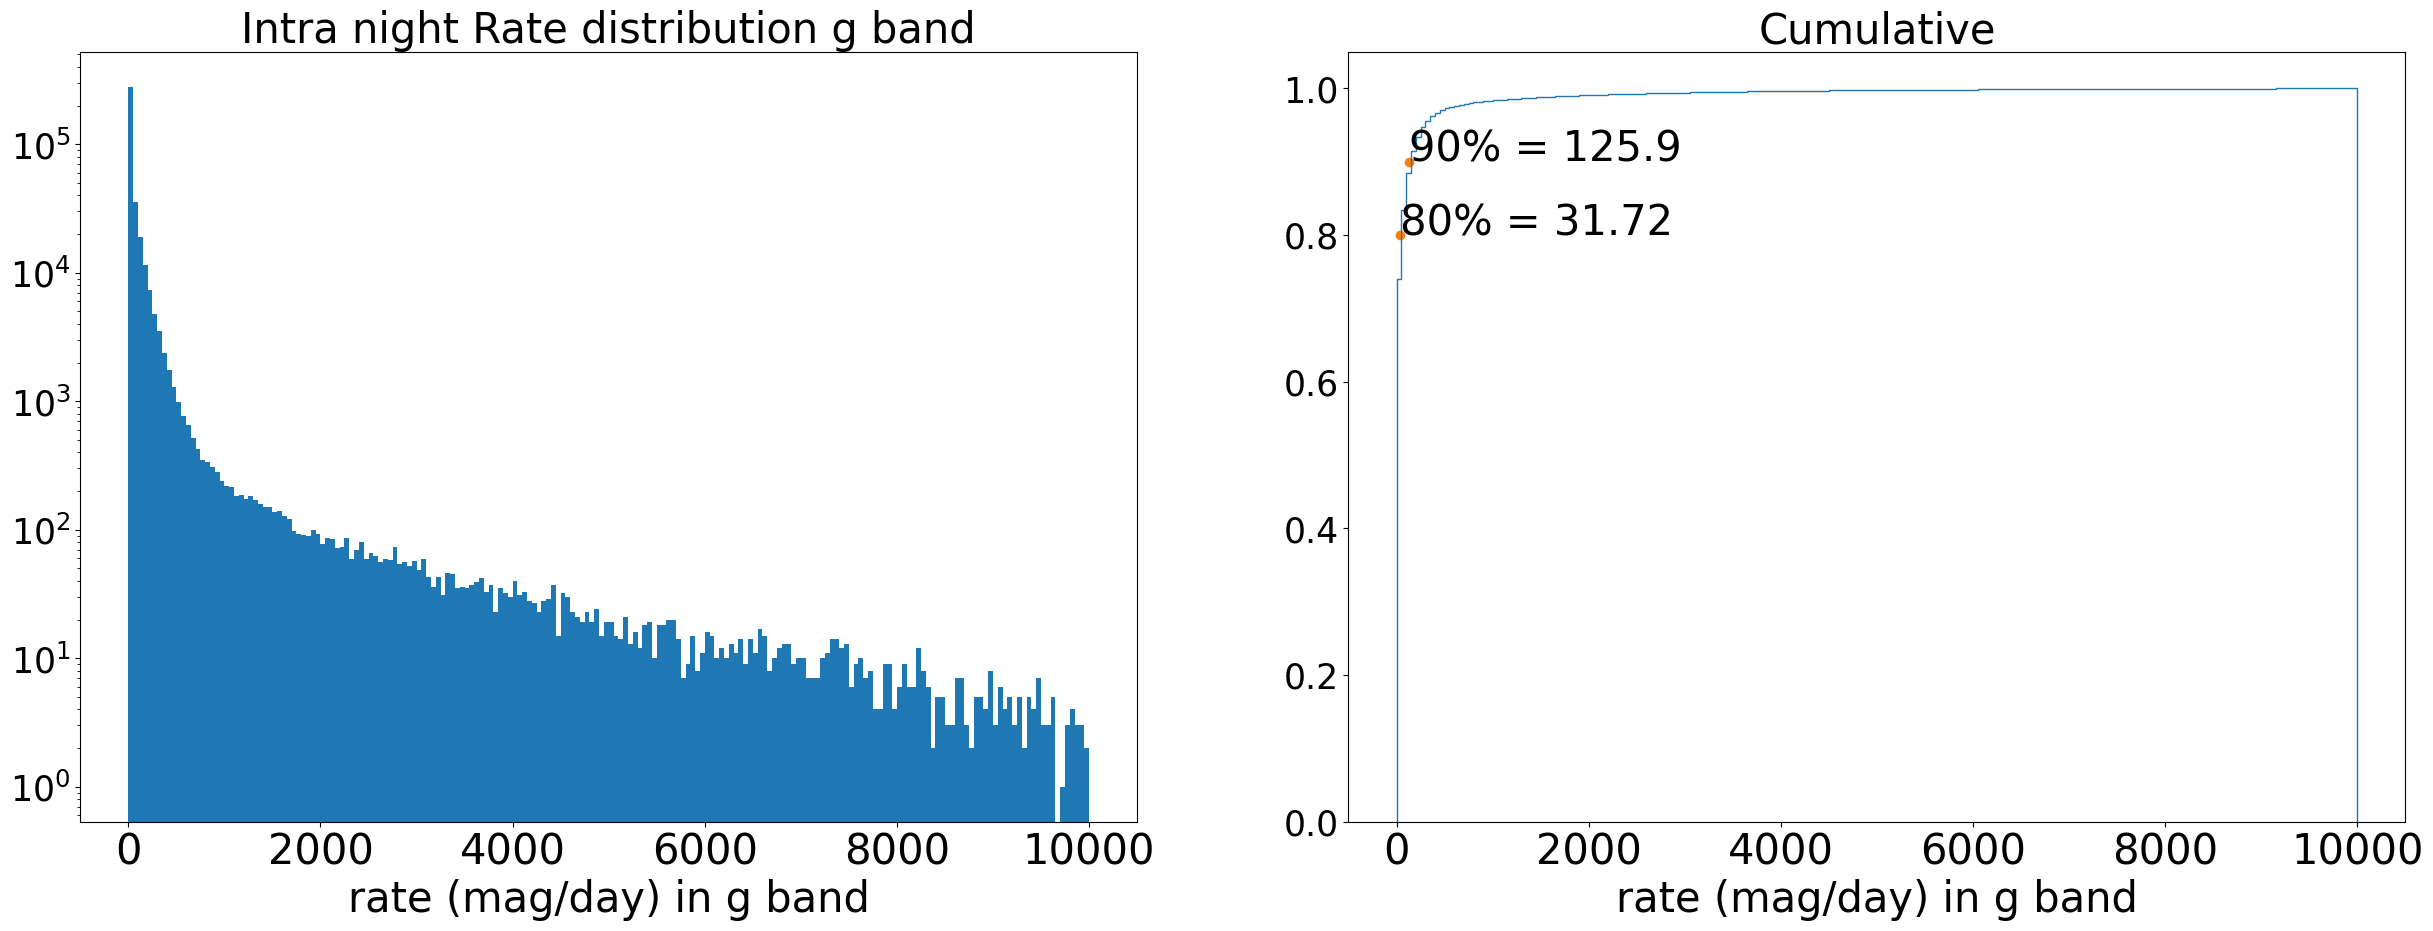

In [11]:
sup_lim = 10000
es.plot_hist_and_cdf(intra_rate_g, [0, sup_lim], "Intra night Rate distribution g band", "rate (mag/day) in g band", "", [0, sup_lim], "Cumulative", "rate (mag/day) in g band", "")

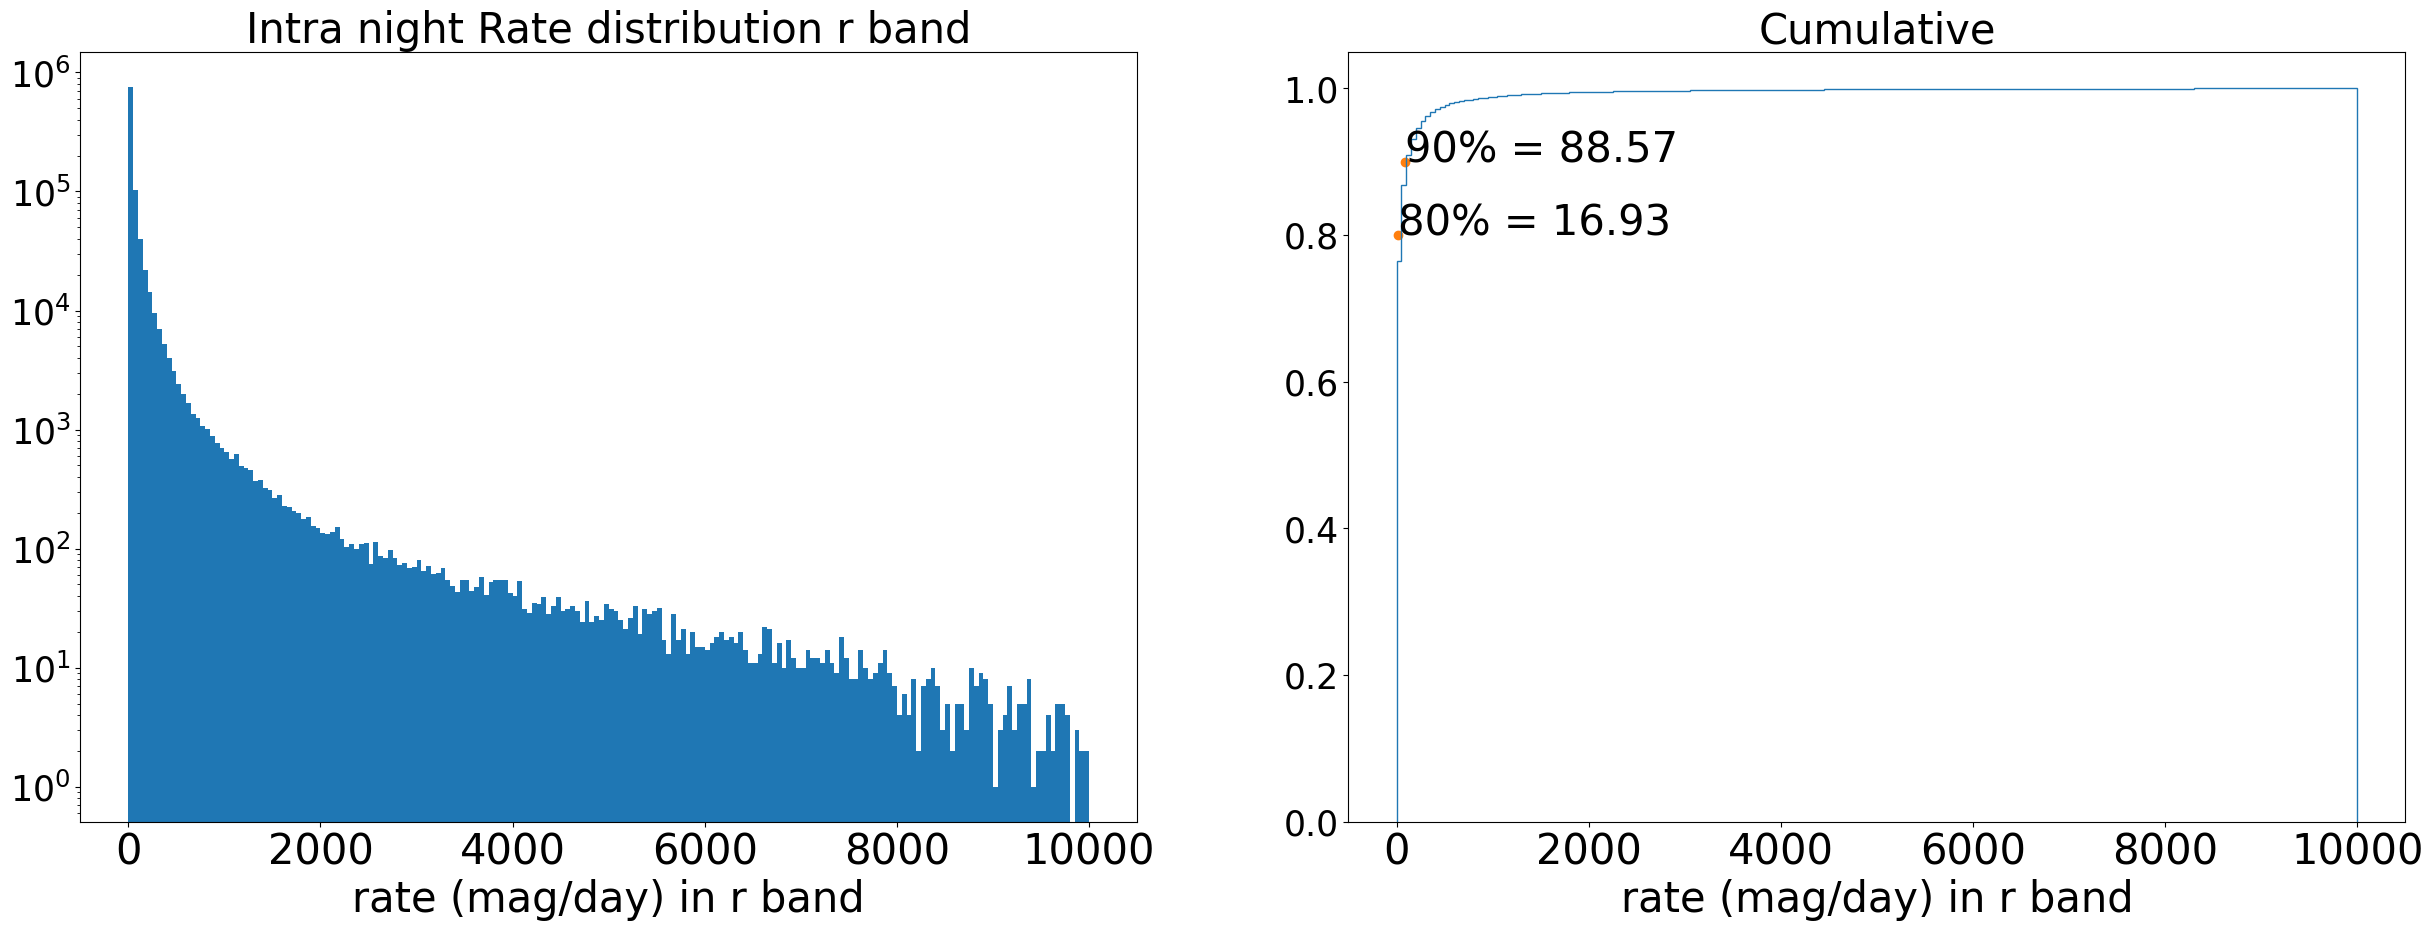

In [12]:
sup_lim = 10000
es.plot_hist_and_cdf(intra_rate_r, [0, sup_lim], "Intra night Rate distribution r band", "rate (mag/day) in r band", "", [0, sup_lim], "Cumulative", "rate (mag/day) in r band", "")

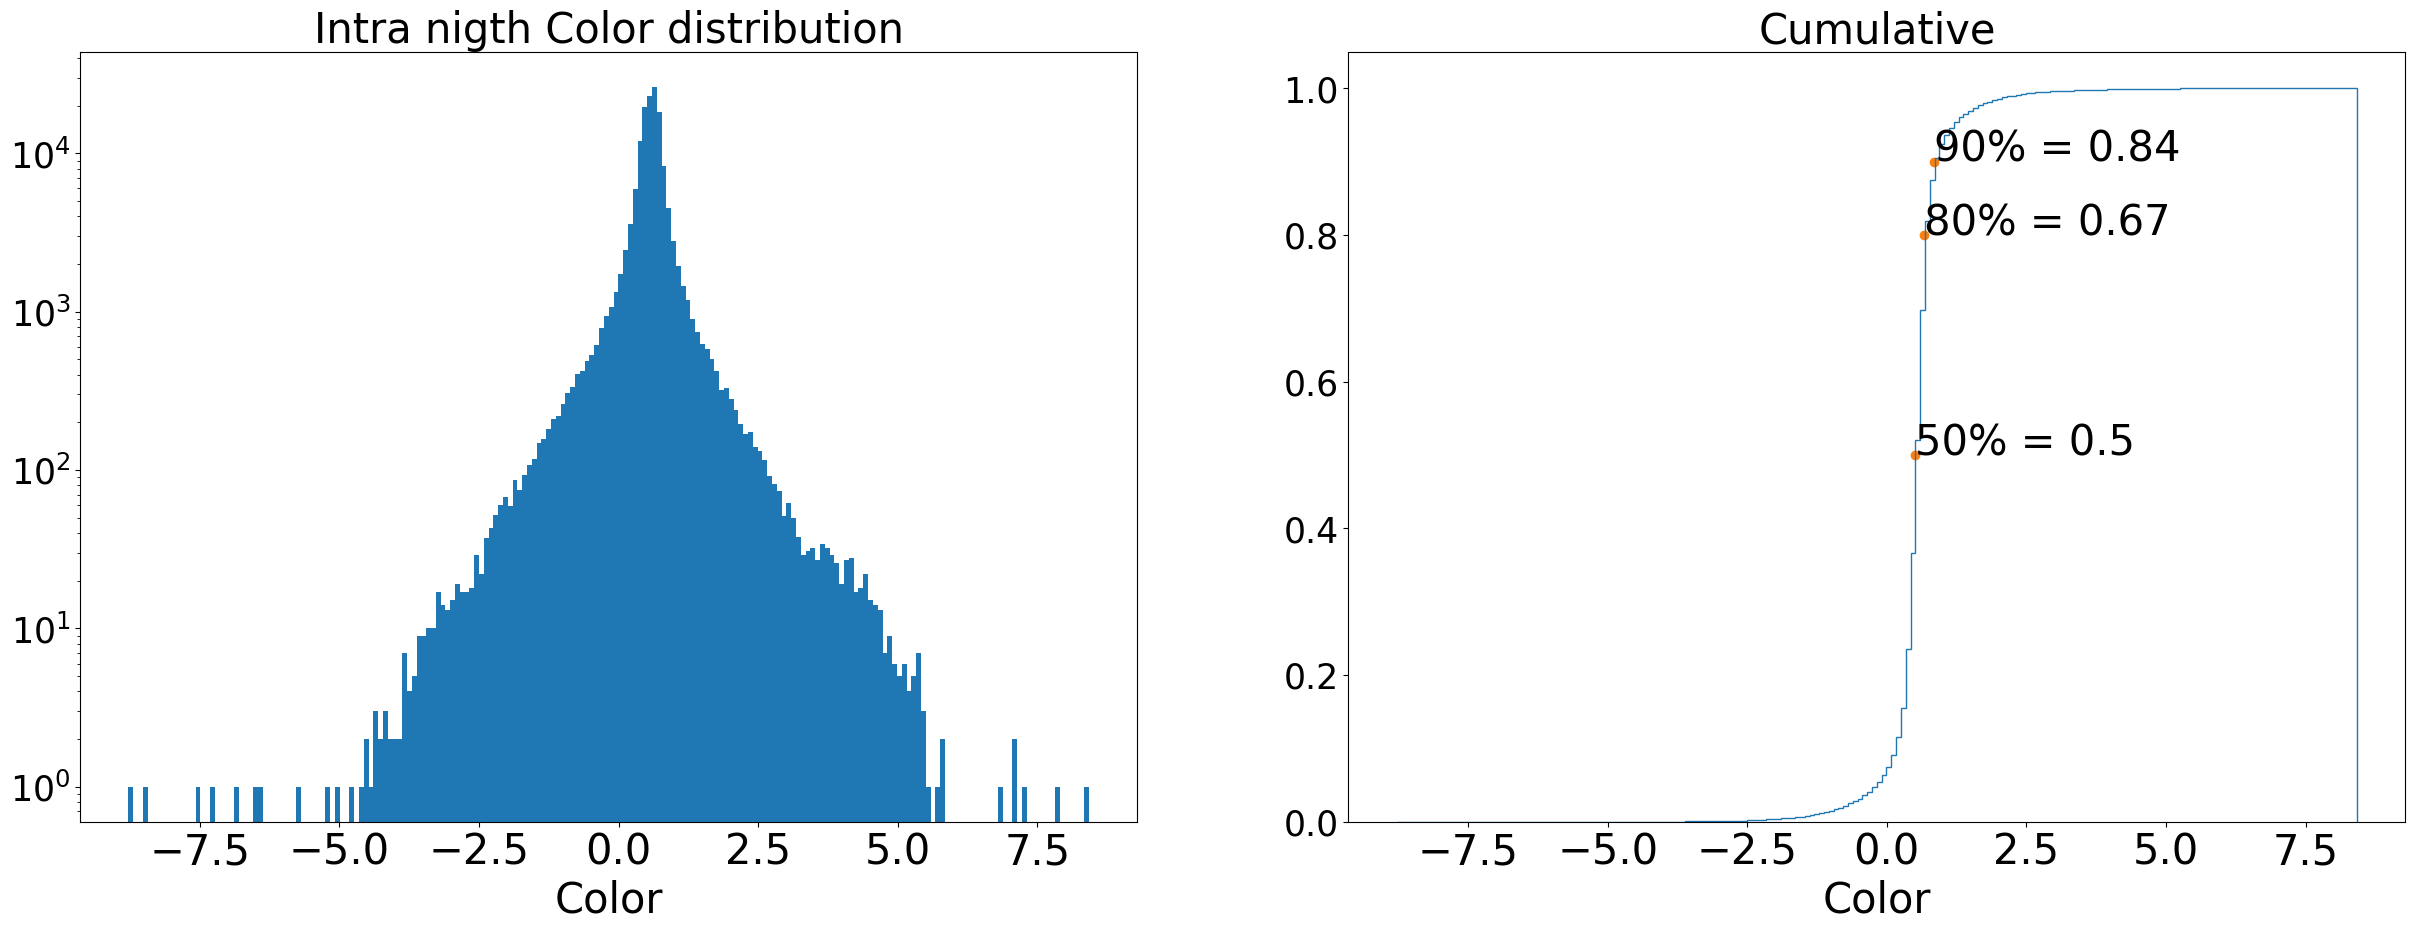

In [13]:
es.plot_hist_and_cdf(intra_color, None, "Intra nigth Color distribution", "Color", "", None, "Cumulative", "Color", "", percent_cdf=[0.5, 0.8, 0.9])